## Laboratorio 1
### Data Science
### Series de timpo

Javier Ovalle, 
José Ángel Morales, 
Ricardo Morales

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tsa as tsa
import statsmodels as sm
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [56]:

dateparse = lambda dates: datetime.strptime(dates, '%Y-%m-%d')
imp = pd.read_csv('IMPORTACIONES.csv', parse_dates=['Fecha'], index_col='Fecha', date_parser=dateparse)
print('\n Parsed Data:')
imp['Diesel'].head()

train_size = int(len(imp) * 0.6)
val_size = int(len(imp) * 0.2)

train_imp = imp[0:train_size]
val_imp = imp[train_size:train_size + val_size]
test_imp = imp[train_size + val_size:len(imp)]




 Parsed Data:


C:\Users\Javier Chiquin\AppData\Local\Temp\ipykernel_30736\344846036.py:2: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  imp = pd.read_csv('IMPORTACIONES.csv', parse_dates=['Fecha'], index_col='Fecha', date_parser=dateparse)


In [57]:
ts_imp_D = train_imp['Diesel']
ts_imp_D.tail(10)

Fecha
2014-10-01     762763.24
2014-11-01    1033873.16
2014-12-01    1004032.65
2015-01-01    1324421.96
2015-02-01     955286.02
2015-03-01    1164885.97
2015-04-01    1130870.79
2015-05-01     954782.75
2015-06-01     862071.77
2015-07-01    1149630.43
Name: Diesel, dtype: float64

### Modelo Arima


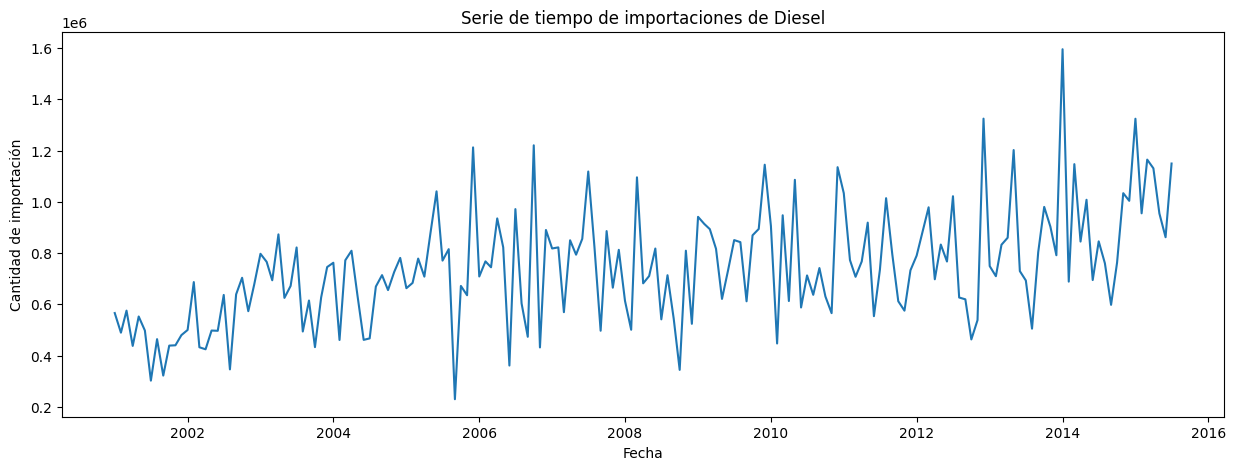

In [58]:
plt.plot(ts_imp_D)
plt.gca().set(title="Serie de tiempo de importaciones de Diesel", xlabel="Fecha", ylabel="Cantidad de importación")
plt.show()

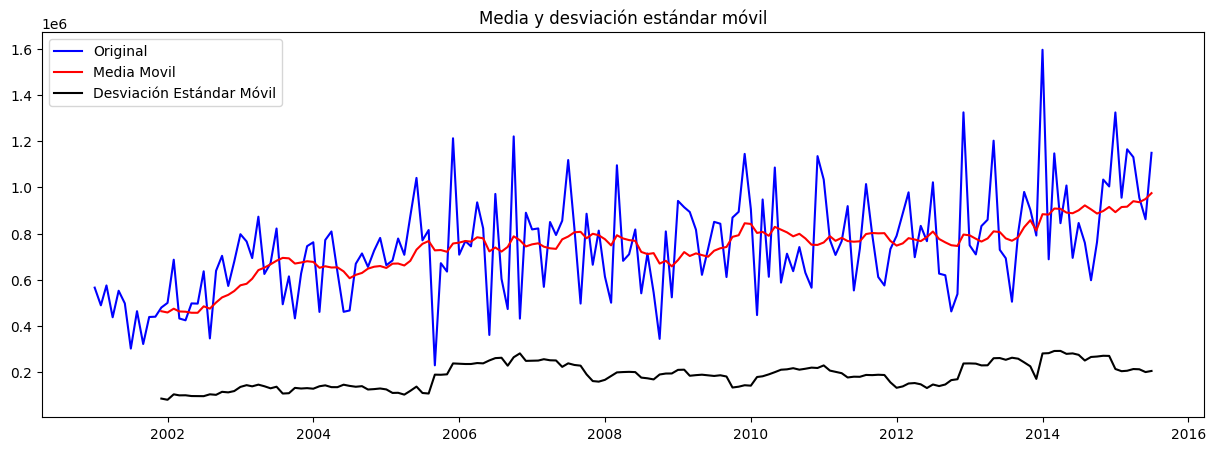

In [59]:
# Se calcula la media móvil y la desviación estandar móvil de los últimos 12 meses.
mediaMovil = ts_imp_D.rolling(window=12).mean()
deMovil = ts_imp_D.rolling(window=12).std()
# Se grafican los resultados.
original = plt.plot(ts_imp_D, color="blue", label="Original")
media = plt.plot(mediaMovil, color='red', label = 'Media Movil')
ds = plt.plot(deMovil,color='black', label = 'Desviación Estándar Móvil')
plt.legend(loc = 'best')
plt.title('Media y desviación estándar móvil')
plt.show(block=False)

Media móvil (rojo): Muestra claramente la tendencia creciente de las importaciones.

Desviación estándar móvil (negro): Indica que la variabilidad también aumenta con el tiempo, lo que es típico en series no estacionarias.

Serie original (azul): Se aprecian fluctuaciones y picos, pero la tendencia general es al alza.

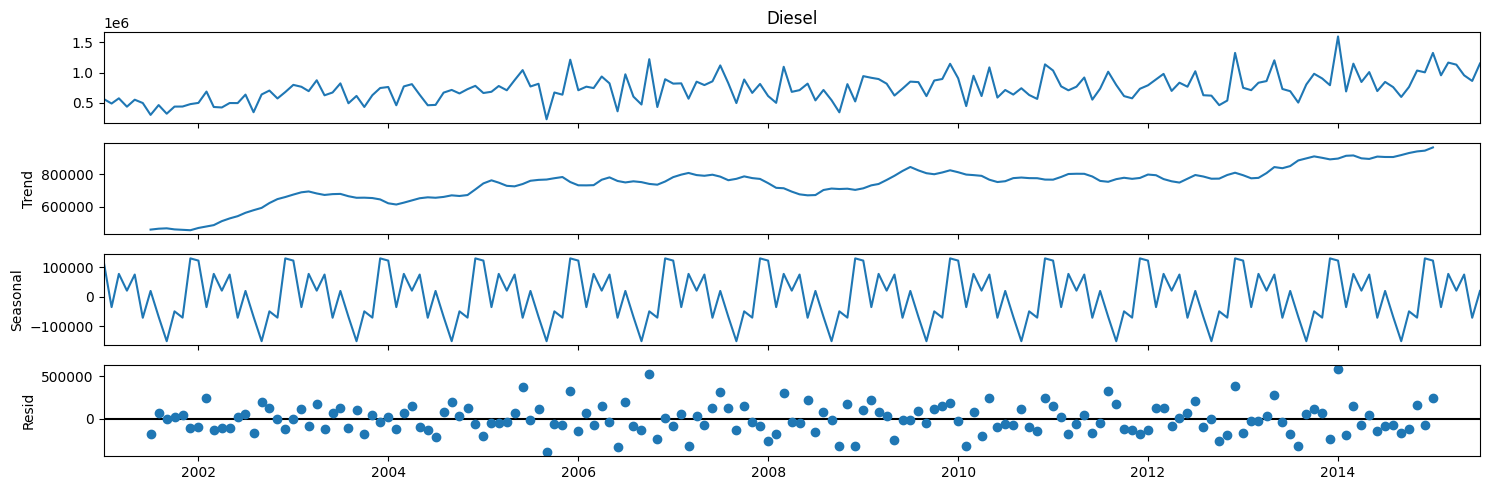

In [60]:
descomposicion = seasonal_decompose(ts_imp_D)
descomposicion.plot();

Tendencia: Se observa un crecimiento sostenido a lo largo de los años.

Estacionalidad: Hay un patrón estacional anual muy claro, con oscilaciones regulares cada año.

Residuales: Los residuos parecen estar centrados en cero, aunque con cierta variabilidad, lo que indica que la descomposición captura bien la tendencia y la estacionalidad.

## Estimar parámetros

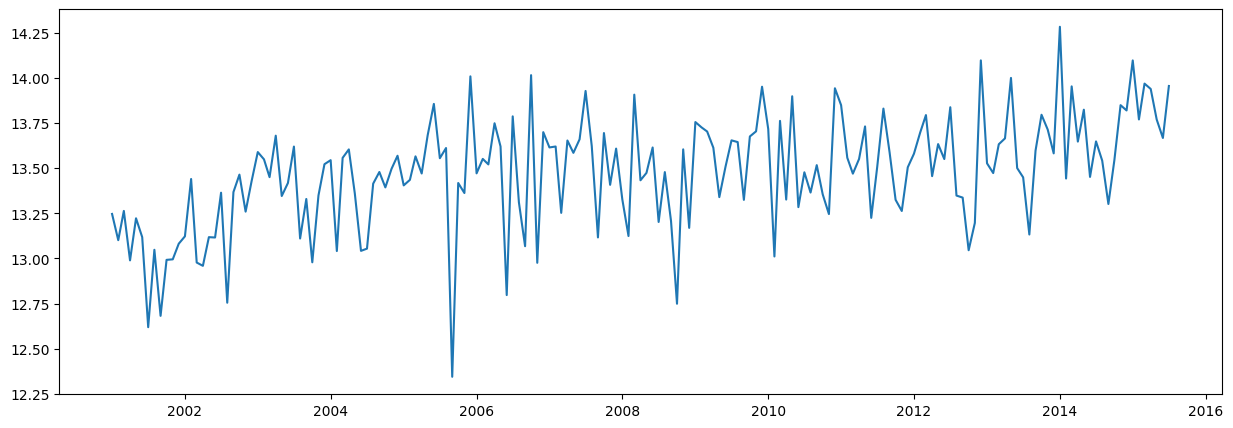

In [61]:
ts_imp_D_log = np.log(ts_imp_D)
plt.plot(ts_imp_D_log)

In [62]:
print('Resultados del Test de Dickey Fuller')
dfTest = adfuller(ts_imp_D, autolag='AIC')
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller
Estadístico de prueba         -1.764567
p-value                        0.398190
# de retardos usados           9.000000
# de observaciones usadas    165.000000
Critical Value (1%)           -3.470616
Critical Value (5%)           -2.879221
Critical Value (10%)          -2.576197
dtype: float64


El p-value es mayor a 0.05 por lo que no se puede rechazar la hipótesis nula de que existen raices unitarias. La serie no es estacionaria en media. Vamos a probar con una diferenciación

In [63]:
print('Resultados del Test de Dickey Fuller para una diferenciación de la serie')
ts_imp_D_diff = ts_imp_D.diff()
ts_imp_D_diff.dropna(inplace=True)
dfTest = adfuller(ts_imp_D_diff)
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller para una diferenciación de la serie
Estadístico de prueba       -7.338280e+00
p-value                      1.081978e-10
# de retardos usados         1.000000e+01
# de observaciones usadas    1.630000e+02
Critical Value (1%)         -3.471119e+00
Critical Value (5%)         -2.879441e+00
Critical Value (10%)        -2.576314e+00
dtype: float64


El valor P es menor a 0.05, por lo que se puede rechazar la hipótesis nula y se puede decir que no hay raices unitarias.

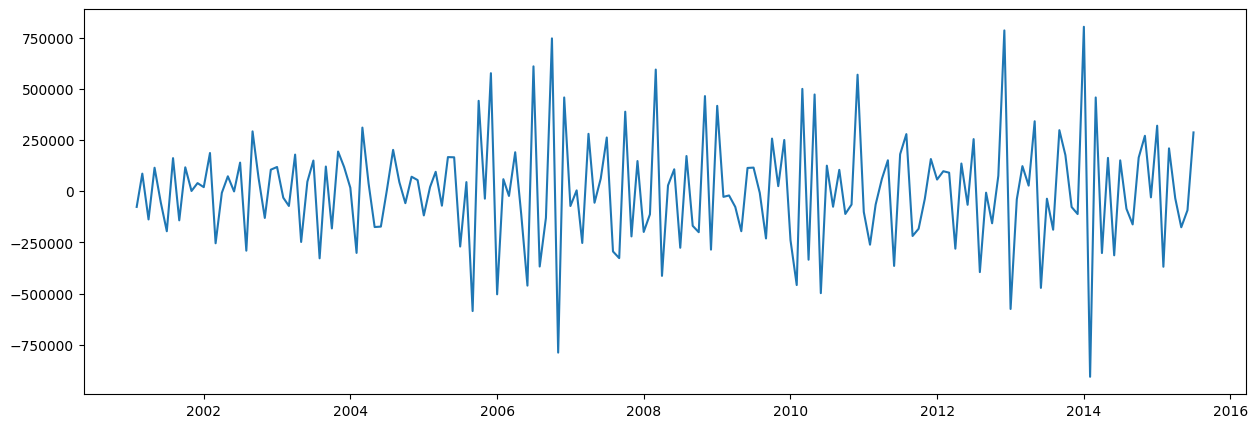

In [64]:
plt.plot(ts_imp_D_diff)

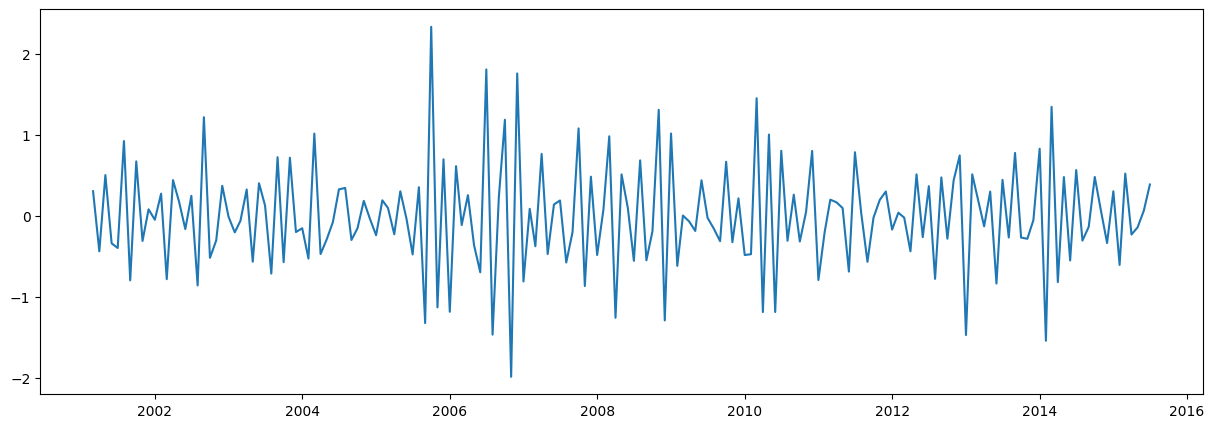

In [65]:
plt.plot(ts_imp_D_log.diff().diff())

Podemos decir que la serie es estacionaria ahora en media y en varianza. Toca ahora estimar los parámetros del modelo.

### Funciones de autocorrelación
#### Modelos teóricos


| Modelo    |                FAC                |                FACP               |
|-----------|:---------------------------------:|:---------------------------------:|
|   **MA(q)**   |         Se anula para j>q         | Decrecimiento rápido. No se anula |
|   **AR(p)**   | Decrecimiento rápido. No se anula |         Se anula para j>p         |
| **ARMA(p,q)** | Decrecimiento rápido. No se anula | Decrecimiento rápido. No se anula |  

In [66]:
ts_imp_D_log_diff = ts_imp_D_log.diff().diff()
ts_imp_D_log_diff.dropna(inplace = True)
tsa_acf = acf(ts_imp_D_log_diff,nlags=5,fft=False)
tsa_pacf = pacf(ts_imp_D_log_diff, nlags=36)
tsa_acf

array([ 1.        , -0.71328884,  0.27136128, -0.0586159 , -0.06641789,
        0.15112594])

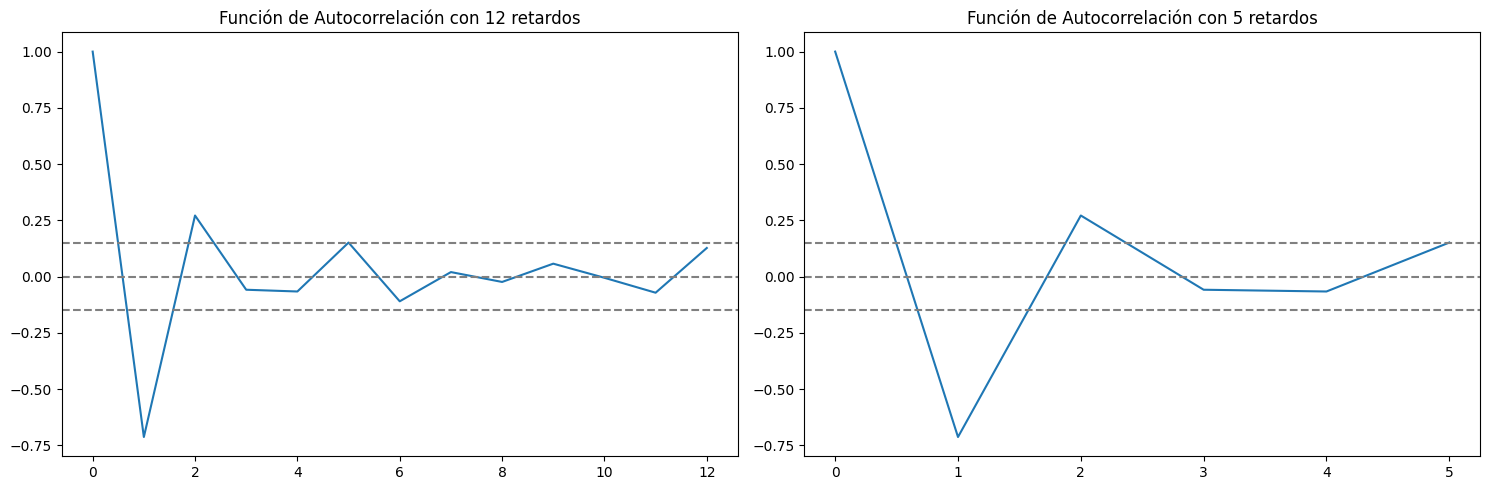

In [67]:
plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

#Plot ACF: 
plt.subplot(121) 
plt.plot(acf(ts_imp_D_log_diff,nlags=12,fft=False))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_imp_D_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_imp_D_log_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación con 12 retardos')

plt.subplot(122) 
plt.plot(acf(ts_imp_D_log_diff,nlags=5,fft=False))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_imp_D_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_imp_D_log_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación con 5 retardos')

plt.tight_layout()

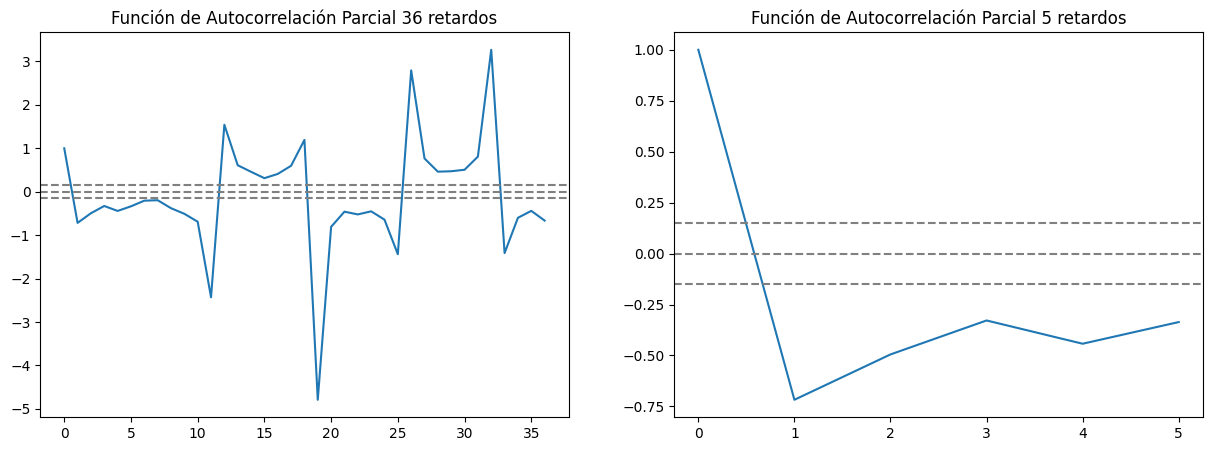

In [68]:
#plot PACF
plt.subplot(121)
plt.plot(pacf(ts_imp_D_log_diff, nlags=36))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_imp_D_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_imp_D_log_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación Parcial 36 retardos')

plt.subplot(122)
plt.plot(pacf(ts_imp_D_log_diff, nlags=5))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_imp_D_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_imp_D_log_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación Parcial 5 retardos')

plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

Como se ve en los gráficos de las funciones de autocorrelación y autocorrelación parcial, podemos intuir que se trata de un modelo teórico similar a un ARMA.
Podíamos probar varios modelos ARIMA:
- p=1, q=1
- p=2, q=1
  
En ambos casos solo es necesaria una diferenciación por lo que d=2

### Estacionalidad

Veamos ahora si hay estacionalidad en la serie. Hagamos un gráfico de la función de autocorrelación usando 36 resagos:

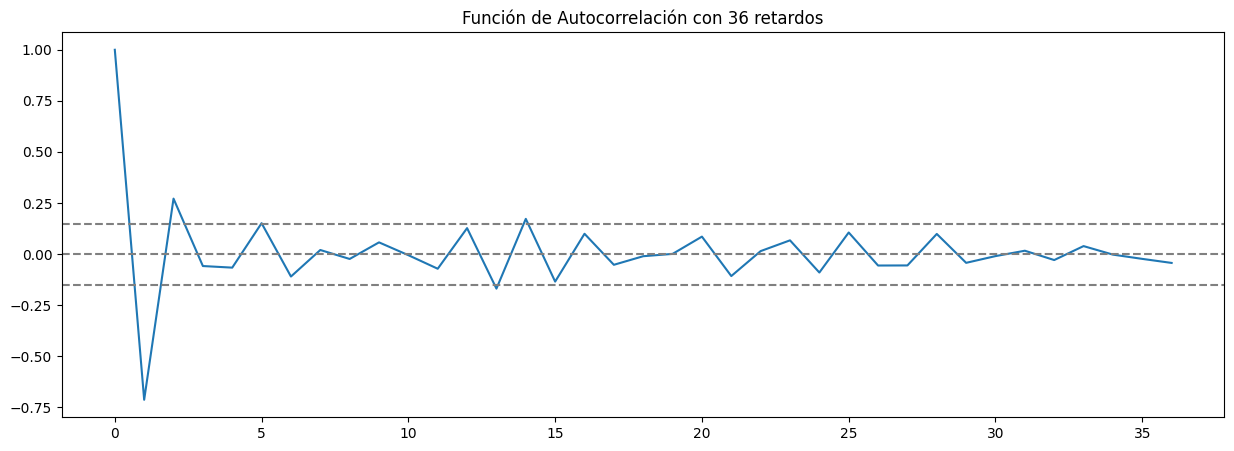

In [69]:
plt.plot(acf(ts_imp_D_log_diff,nlags=36,fft=False))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_imp_D_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_imp_D_log_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación con 36 retardos')
plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

La serie diferenciada no muestra autocorrelación significativa en los rezagos anuales, lo que sugiere que la estacionalidad fue eliminada o no es fuerte en la serie diferenciada.

In [70]:
ts_imp_D_log_D = ts_imp_D_log.diff(12)
ts_imp_D_log_D.dropna(inplace=True)

Text(0.5, 1.0, 'Función de Autocorrelación Parcial 5 retardos')

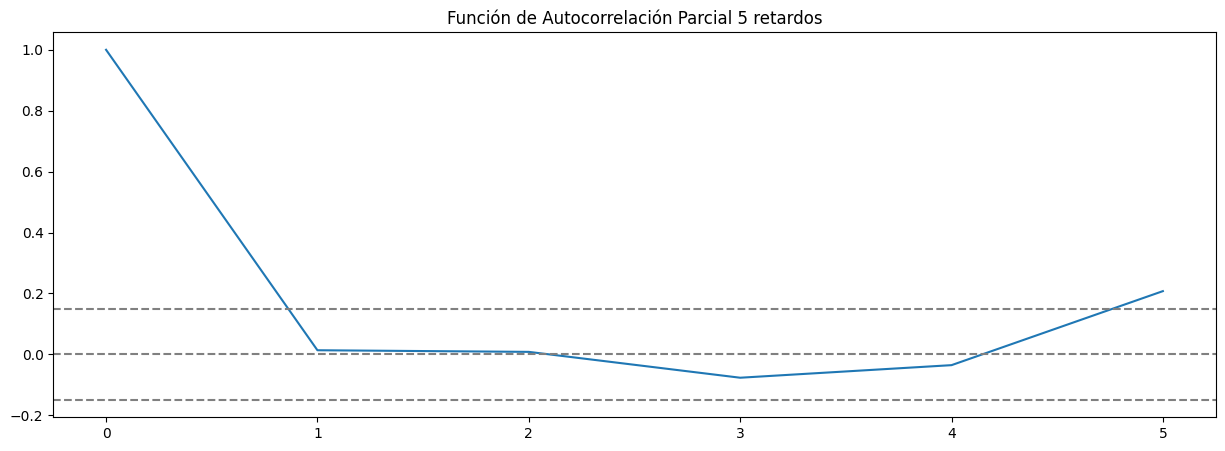

In [71]:
plt.plot(pacf(ts_imp_D_log_D, nlags=5))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_imp_D_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_imp_D_log_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación Parcial 5 retardos')

In [72]:
modelo121 = SARIMAX(ts_imp_D_log, order=(1,2,1), seasonal_order=(2,1,0,12), enforce_stationarity=False, enforce_invertibility=False)
resultado_m121 = modelo121.fit()
print(resultado_m121.summary().tables[1])

c:\Users\Javier Chiquin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Javier Chiquin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5974      0.073     -8.193      0.000      -0.740      -0.454
ma.L1         -1.0000    495.226     -0.002      0.998    -971.626     969.625
ar.S.L12      -0.7417      0.093     -7.989      0.000      -0.924      -0.560
ar.S.L24      -0.3723      0.096     -3.867      0.000      -0.561      -0.184
sigma2         0.1302     64.482      0.002      0.998    -126.253     126.513


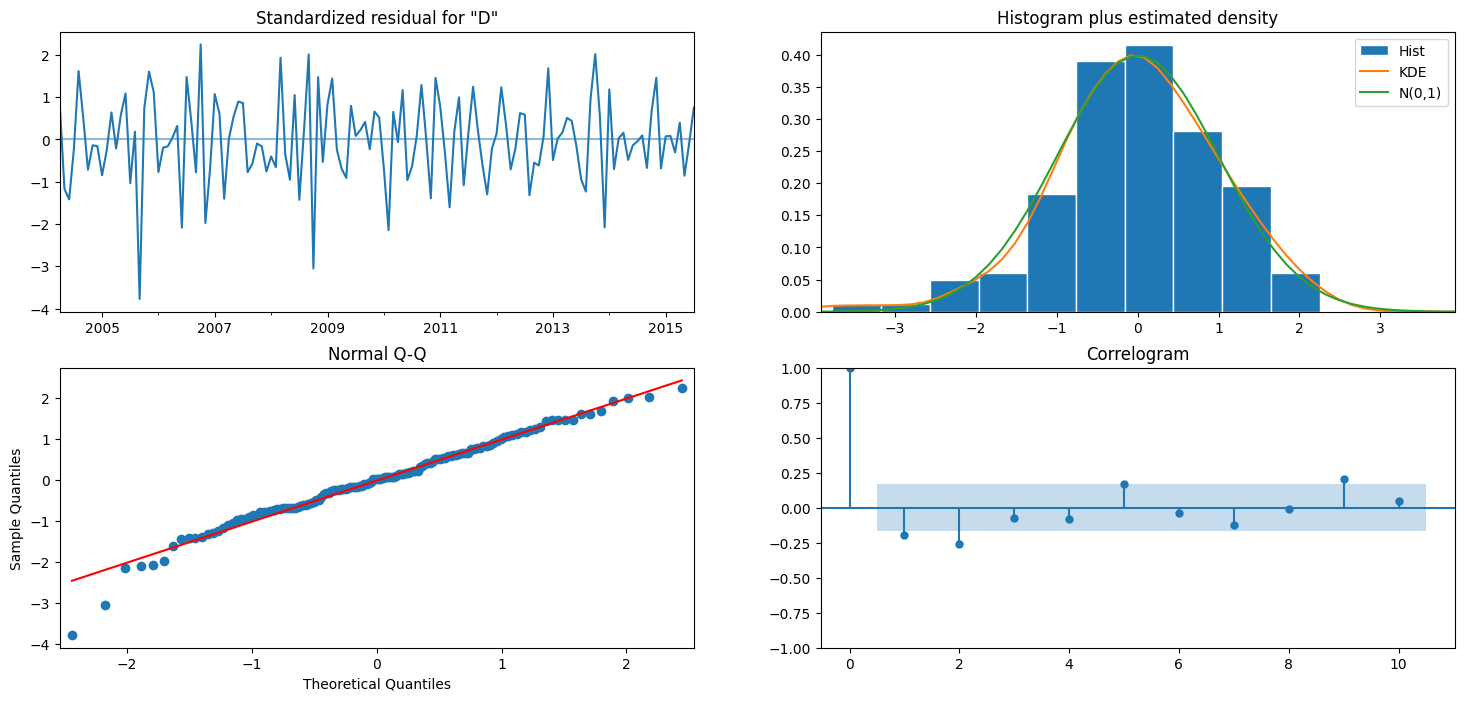

In [73]:
resultado_m121.plot_diagnostics(figsize=(18, 8))
plt.show()

 Como se puede obserevar los residuos presentan una distribución normal, y parecen comportarse como un ruido blanco dado que en el correlograma no hay autocorrelaciones significativas

In [74]:
modelo221 = SARIMAX(ts_imp_D_log, order=(2,2,1), seasonal_order=(2,1,0,12), enforce_stationarity=False, enforce_invertibility=False)
resultado_m221 = modelo221.fit()
print(resultado_m221.summary().tables[1])

c:\Users\Javier Chiquin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Javier Chiquin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8162      0.085     -9.581      0.000      -0.983      -0.649
ar.L2         -0.3167      0.073     -4.341      0.000      -0.460      -0.174
ma.L1         -1.0000    404.903     -0.002      0.998    -794.595     792.595
ar.S.L12      -0.8015      0.097     -8.288      0.000      -0.991      -0.612
ar.S.L24      -0.3524      0.095     -3.703      0.000      -0.539      -0.166
sigma2         0.1173     47.505      0.002      0.998     -92.990      93.225


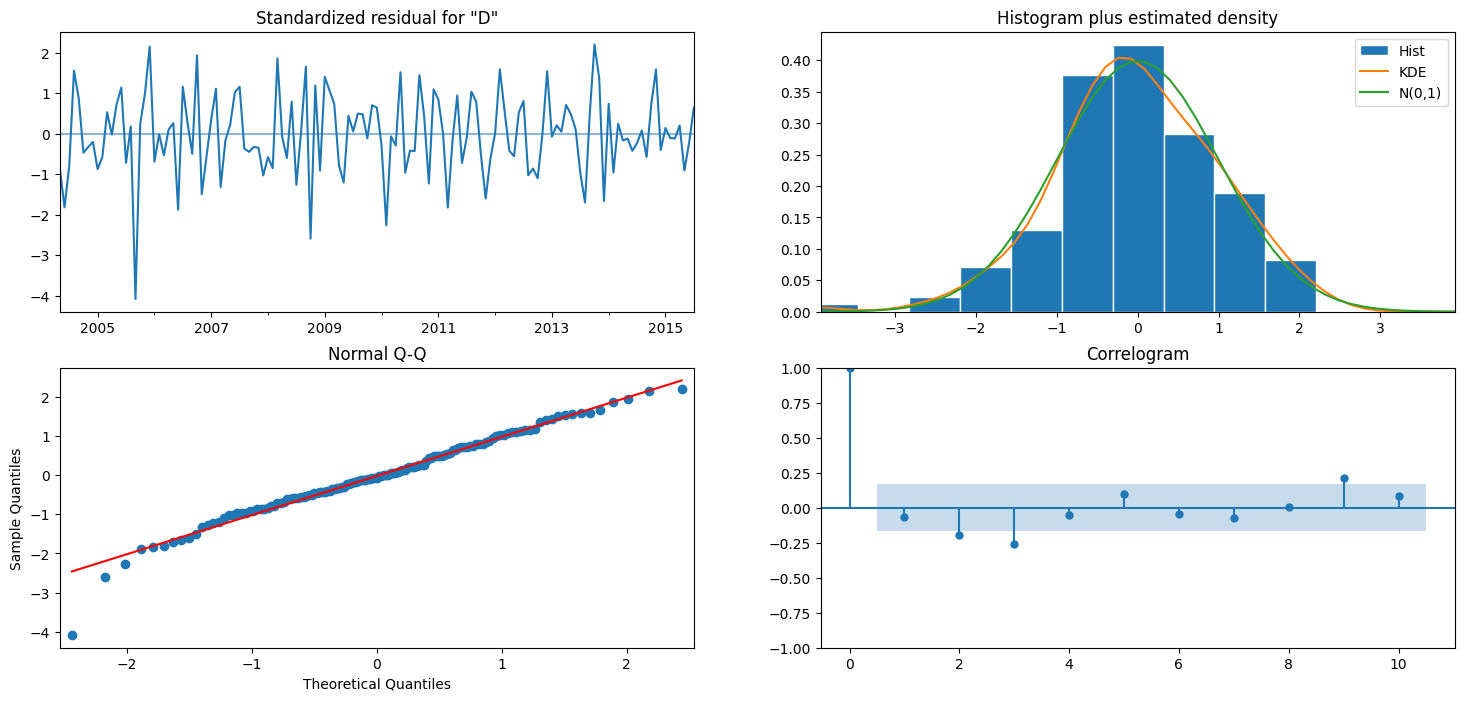

In [75]:
resultado_m221.plot_diagnostics(figsize=(18, 8))
plt.show()

En este otro modelo tampoco existen autocorrelaciones significativas y parecen estar distribuidos de forma normal

In [76]:
print("Resultados de AIC (Akaike information criterion)")
print("Modelo 121=",resultado_m121.aic)
print("Modelo 221=",resultado_m221.aic)
print("Resultados de BIC (Bayesian information criterion)")
print("Modelo 121=",resultado_m121.bic)
print("Modelo 221=",resultado_m221.bic)

Resultados de AIC (Akaike information criterion)
Modelo 121= 123.37338633892195
Modelo 221= 110.2093044267049
Resultados de BIC (Bayesian information criterion)
Modelo 121= 137.9366607676022
Modelo 221= 127.64095309733548


## Predicción con el mejor modelo

In [77]:
test_imp.index[0]

Timestamp('2020-06-01 00:00:00')

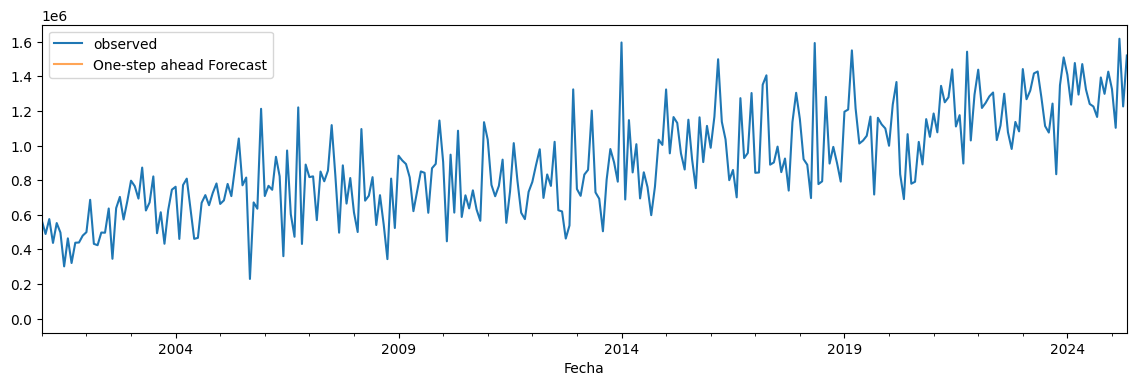

In [78]:
pred = resultado_m121.get_prediction(start=test_imp.index[0], dynamic=False)
pred_ci = pred.conf_int()
ax = imp['Diesel'].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 4))
ax.fill_between( pred_ci.iloc[:,0],
                pred_ci.iloc[:,1], color='k', alpha=.2)
#ax.set_xlabel('Date')
#ax.set_ylabel('Retail_sold')
plt.legend()
plt.show()

pred

In [81]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Asegúrate de que los índices estén alineados
y_true_arima = test_imp['Diesel']
# Alinear ambos series al índice común
common_idx = y_true_arima.index.intersection(y_pred_arima.index)
y_true_aligned = y_true_arima.loc[common_idx]
y_pred_aligned = y_pred_arima.loc[common_idx]

# Si usaste log para entrenar, recuerda deshacer la transformación:
y_pred_aligned = np.exp(y_pred_aligned)

rmse_arima = np.sqrt(mean_squared_error(y_true_aligned, y_pred_aligned))
mae_arima = mean_absolute_error(y_true_aligned, y_pred_aligned)

print(f"ARIMA - RMSE (test): {rmse_arima:.2f}")
print(f"ARIMA - MAE  (test): {mae_arima:.2f}")

ARIMA - RMSE (test): 742129.65
ARIMA - MAE  (test): 742129.65
